In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as ss
from tqdm import tqdm

In [2]:
pd.options.display.max_columns = 50
pd.options.display.max_rows = 100

In [3]:
summary = pd.read_csv('data/summary.csv')

summary.sort_values(['day', 'assessment_end_time'], inplace=True)
summary.reset_index(drop=True, inplace=True)

In [4]:
summary_train = summary[summary['day'] <= 45]

In [5]:
summary_train.head()

,Unnamed: 0,arrival_time,assessment_end_time,assessment_start_time,consultation_end_time,consultation_start_time,day,duration,pain,patient,priority,temperature
0,1,280,741,308,1620,773,1,847,no pain,1,urgent,36.6
1,2,288,851,764,1881,905,1,976,severe pain,2,normal,36.7
2,0,430,1055,878,1595,1084,1,510,severe pain,3,normal,36.8
3,3,944,1244,1089,2105,1294,1,810,severe pain,4,urgent,36.6
4,11,1139,1351,1267,3322,1378,1,1943,severe pain,5,urgent,36.2


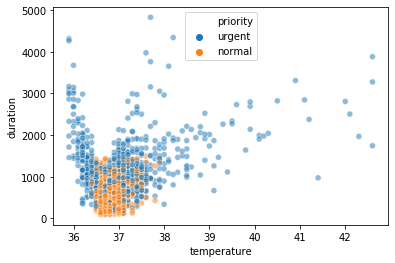

In [6]:
sns.scatterplot(x='temperature', y='duration', data=summary_train, hue='priority', alpha=.5);

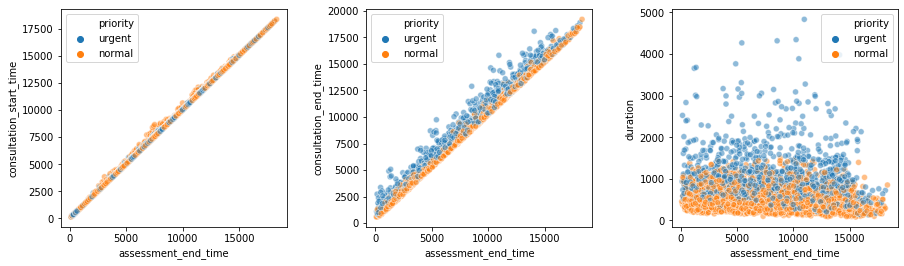

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

sns.scatterplot(x='assessment_end_time',
                y='consultation_start_time',
                data=summary_train,
                hue='priority',
                alpha=.5,
                ax=ax[0])

sns.scatterplot(x='assessment_end_time',
                y='consultation_end_time',
                data=summary_train,
                hue='priority',
                alpha=.5,
                ax=ax[1])

sns.scatterplot(x='assessment_end_time',
                y='duration',
                data=summary_train,
                hue='priority',
                alpha=.5,
                ax=ax[2])

plt.subplots_adjust(wspace=.35);

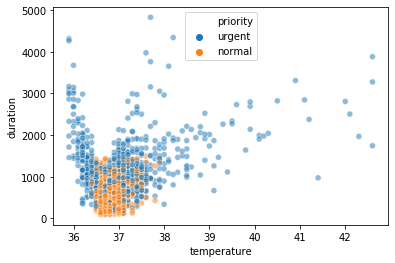

In [8]:
sns.scatterplot(x='temperature', y='duration', data=summary_train, hue='priority', alpha=.5);

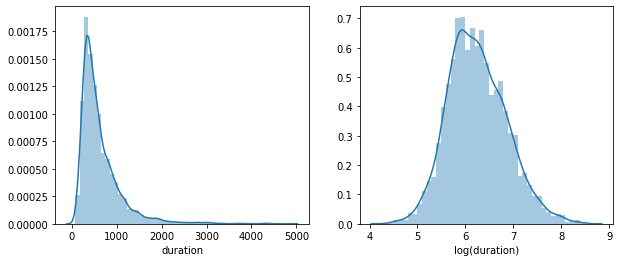

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.distplot(summary['duration'], ax=ax[0])
sns.distplot(np.log(summary['duration']), axlabel='log(duration)', ax=ax[1]);

In [10]:
summary['consultation_end_time'] = np.log(summary['duration'])

In [11]:
summary['temp_cat'] = pd.cut(summary['temperature'],
                             bins=[float('-inf'), 36.5, 37.5, float('inf')],
                             labels=['hypothermia', 'normal', 'fever'])

In [12]:
priority_map = {'normal': 1, 'urgent': 2}
summary['priority_enc'] = summary['priority'].map(priority_map)

pain_map = {'no pain': 1, 'moderate pain': 2, 'severe pain': 3}
summary['pain_enc'] = summary['pain'].map(pain_map)

temp_map = {'hypothermia': 2, 'normal': 1, 'fever': 2}
summary['temp_cat_enc'] = summary['temp_cat'].map(temp_map)

In [13]:
summary = pd.get_dummies(summary, columns=['pain', 'temp_cat'])

In [14]:
summary['pain_no pain:temp_cat_hypothermia'] =\
summary['pain_no pain'] * summary['temp_cat_hypothermia']
summary['pain_moderate pain:temp_cat_hypothermia'] =\
summary['pain_moderate pain'] * summary['temp_cat_hypothermia']
summary['pain_severe pain:temp_cat_hypothermia'] =\
summary['pain_severe pain'] * summary['temp_cat_hypothermia']

summary['pain_no pain:temp_cat_normal'] = summary['pain_no pain'] * summary['temp_cat_normal']
summary['pain_moderate pain:temp_cat_normal'] = summary['pain_moderate pain'] * summary['temp_cat_normal']
summary['pain_severe pain:temp_cat_normal'] = summary['pain_severe pain'] * summary['temp_cat_normal']

summary['pain_no pain:temp_cat_fever'] = summary['pain_no pain'] * summary['temp_cat_fever']
summary['pain_moderate pain:temp_cat_fever'] = summary['pain_moderate pain'] * summary['temp_cat_fever']
summary['pain_severe pain:temp_cat_fever'] = summary['pain_severe pain'] * summary['temp_cat_fever']

summary.drop(['pain_no pain', 'pain_moderate pain', 'pain_severe pain',
              'temp_cat_hypothermia', 'temp_cat_normal', 'temp_cat_fever'],
             axis=1, inplace=True)

In [15]:
summary.head()

,Unnamed: 0,arrival_time,assessment_end_time,assessment_start_time,consultation_end_time,consultation_start_time,day,duration,patient,priority,temperature,consultation_end_time,priority_enc,pain_enc,temp_cat_enc,pain_no pain:temp_cat_hypothermia,pain_moderate pain:temp_cat_hypothermia,pain_severe pain:temp_cat_hypothermia,pain_no pain:temp_cat_normal,pain_moderate pain:temp_cat_normal,pain_severe pain:temp_cat_normal,pain_no pain:temp_cat_fever,pain_moderate pain:temp_cat_fever,pain_severe pain:temp_cat_fever
0,1,280,741,308,1620,773,1,847,1,urgent,36.6,6.741701,2,1,1,0,0,0,1,0,0,0,0,0
1,2,288,851,764,1881,905,1,976,2,normal,36.7,6.883463,1,3,1,0,0,0,0,0,1,0,0,0
2,0,430,1055,878,1595,1084,1,510,3,normal,36.8,6.234411,1,3,1,0,0,0,0,0,1,0,0,0
3,3,944,1244,1089,2105,1294,1,810,4,urgent,36.6,6.697034,2,3,1,0,0,0,0,0,1,0,0,0
4,11,1139,1351,1267,3322,1378,1,1943,5,urgent,36.2,7.571988,2,3,2,0,0,1,0,0,0,0,0,0


In [16]:
def create_new_features(df):
    '''
    Given a dataframe, returns dataframe with added new features:
        free_doctors: number of doctors available after patient has passed triage
        queue_size: queue size after patient has passed triage
        urgents_on_queue: number of urgent priority patients on queue after patient has passed triage
    '''
    
    free_docs = [6]
    q_urg = [list()]
    q_norm = [list()]
    q_real = [list()]
    urgs_on_q = [0]
    q_size = 0
    nonbusy_docs = 0
    consult_endtime_ls = [df.loc[0, 'consultation_end_time']]
    
    for i in range(1, len(df)):
        nonbusy_docs = (df.loc[i, 'assessment_end_time'] >= consult_endtime_ls).sum()
        consult_endtime_ls = consult_endtime_ls[nonbusy_docs:]

        if free_docs[i - 1] > 1:
            free_docs.append(free_docs[i - 1] - 1 + nonbusy_docs)
            consult_endtime_ls.append(df.loc[i, 'consultation_end_time'])
            consult_endtime_ls = sorted(consult_endtime_ls)
            q_urg.append(q_urg[i - 1])
            q_norm.append(q_norm[i - 1])
            q_real.append(q_urg[i] + q_norm[i])
            urgs_on_q.append(urgs_on_q[i - 1])
        elif nonbusy_docs == 0:
            free_docs.append(0)
            if df.loc[i, 'priority'] == 'urgent':
                urgs_on_q.append(urgs_on_q[i - 1] + 1)
                q_urg.append(q_urg[i - 1] + [i])
                q_norm.append(q_norm[i - 1])
            else:
                urgs_on_q.append(urgs_on_q[i - 1])
                q_urg.append(q_urg[i - 1])
                q_norm.append(q_norm[i - 1] + [i])
            q_real.append(q_urg[i] + q_norm[i])
            q_size = len(q_real[i])
        elif q_size == 0:
            free_docs.append(free_docs[i - 1] - 1 + nonbusy_docs)
            q_urg.append(q_urg[i - 1])
            q_norm.append(q_norm[i - 1])
            q_real.append(q_urg[i] + q_norm[i])
            urgs_on_q.append(urgs_on_q[i - 1])
            consult_endtime_ls.append(df.loc[i, 'consultation_end_time'])
            consult_endtime_ls = sorted(consult_endtime_ls)
        else:
            free_docs.append(np.max([free_docs[i - 1] + nonbusy_docs - q_size, 0]))
            if df.loc[i, 'priority'] == 'urgent':
                urgs_on_q.append(urgs_on_q[i - 1] + 1)
                q_urg.append(q_urg[i - 1] + [i])
                q_norm.append(q_norm[i - 1])
            else:
                urgs_on_q.append(urgs_on_q[i - 1])
                q_urg.append(q_urg[i - 1])
                q_norm.append(q_norm[i - 1] + [i])
            q_real.append(q_urg[i] + q_norm[i])
            q_size = len(q_real[i])
            while q_size > 0 and nonbusy_docs > 0:
                patient = q_real[i].pop(0)
                if df.loc[patient, 'priority'] == 'urgent':
                    urgs_on_q[i] -= 1
                    q_urg[i].pop(0)
                else:
                    q_norm[i].pop(0)
                consult_endtime_ls.append(df.loc[patient, 'consultation_end_time'])
                consult_endtime_ls = sorted(consult_endtime_ls)
                q_size -= 1
                nonbusy_docs -= 1
                
#     new_features = pd.DataFrame([free_docs, pd.Series(q_real).apply(lambda x: len(x)), urgs_on_q],
#                                 index=['free_doctors', 'queue_size', 'urgents_on_queue']).T
    
    new_features = pd.DataFrame([free_docs, pd.Series(q_real).apply(lambda x: len(x))],
                            index=['free_doctors', 'queue_size']).T
    
    return pd.concat([df, new_features], axis=1)

In [17]:
summary_new = pd.DataFrame(columns=summary.columns)
for i in summary['day'].unique():
    df = create_new_features(summary[summary['day'] == i].reset_index(drop=True))
    summary_new = pd.concat([summary_new, df], axis=0)

cols_to_drop = ['Unnamed: 0', 'arrival_time', 'assessment_start_time', 'patient',
                'priority', 'consultation_end_time', 'duration', 'temperature']

summary_new = summary_new.drop(cols_to_drop, axis=1).reset_index(drop=True)

In [18]:
summary_new_train = summary_new[summary_new['day'] <= 45]
summary_new_test = summary_new[summary_new['day'] > 45]

In [19]:
best_params_ls = []
train_rmse_ls = []
val_rmse_ls = []

def get_best_params_and_rmse(df):
    '''
    Given df, returns:
        - a list of the parameters of the best model for each day
        - a list of the cv train rmse of the best model for each day
        - a list of the cv validation rmse of the best model for each day
    '''
    
    for i in tqdm(df['day'].unique()):
        X_train = df[df['day'] == i].drop(['day', 'consultation_end_time'], axis=1)
        y_train = df.loc[df['day'] == i, 'consultation_end_time']

        tscv = TimeSeriesSplit(n_splits=5)

        ridge = Ridge(normalize=True, random_state=42)
        ridge_params = {'alpha': ss.uniform(0, 6)}

        rscv = RandomizedSearchCV(ridge,
                                  ridge_params,
#                                   n_iter=1000,
                                  n_iter=100,
                                  scoring='neg_root_mean_squared_error',
                                  n_jobs=-1,
                                  cv=tscv,
                                  verbose=1,
                                  random_state=42,
                                  return_train_score=True)

        rscv.fit(X_train, y_train)

        best_params_ls.append(rscv.best_params_)

        cv_results = pd.DataFrame(rscv.cv_results_)
        train_rmse_ls.append(-cv_results.loc[rscv.best_index_, 'mean_train_score'])
        val_rmse_ls.append(-cv_results.loc[rscv.best_index_, 'mean_test_score'])
        
    return best_params_ls, train_rmse_ls, val_rmse_ls

In [20]:
best_params_ls, train_rmse_ls, val_rmse_ls = get_best_params_and_rmse(summary_new_train)

results_train_df = pd.DataFrame([best_params_ls, train_rmse_ls, val_rmse_ls],
                                 index=['best_params', 'train_rmse', 'val_rmse']).T

  0%|          | 0/45 [00:00<?, ?it/s]

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    3.5s finished
  2%|▏         | 1/45 [00:03<02:36,  3.57s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished
  4%|▍         | 2/45 [00:04<01:58,  2.76s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished
  7%|▋         | 3/45 [00:05<01:32,  2.21s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
  9%|▉         | 4/45 [00:06<01:13,  1.80s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
 11%|█         | 5/45 [00:07<01:00,  1.52s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
 13%|█▎        | 6/45 [00:07<00:51,  1.32s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
 16%|█▌        | 7/45 [00:08<00:44,  1.16s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished
 18%|█▊        | 8/45 [00:09<00:36,  1.00it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished
 20%|██        | 9/45 [00:09<00:32,  1.12it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished
 22%|██▏       | 10/45 [00:10<00:28,  1.23it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished
 24%|██▍       | 11/45 [00:11<00:26,  1.29it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished
 27%|██▋       | 12/45 [00:11<00:24,  1.37it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished
 29%|██▉       | 13/45 [00:12<00:22,  1.41it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished
 31%|███       | 14/45 [00:13<00:20,  1.49it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished
 33%|███▎      | 15/45 [00:13<00:19,  1.55it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished
 36%|███▌      | 16/45 [00:14<00:18,  1.58it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished
 38%|███▊      | 17/45 [00:14<00:17,  1.61it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished
 40%|████      | 18/45 [00:15<00:16,  1.65it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished
 42%|████▏     | 19/45 [00:16<00:15,  1.67it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished
 44%|████▍     | 20/45 [00:16<00:14,  1.68it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished
 47%|████▋     | 21/45 [00:17<00:14,  1.70it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished
 49%|████▉     | 22/45 [00:17<00:13,  1.71it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished
 51%|█████     | 23/45 [00:18<00:12,  1.70it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished
 53%|█████▎    | 24/45 [00:19<00:12,  1.70it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished
 56%|█████▌    | 25/45 [00:19<00:11,  1.69it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished
 58%|█████▊    | 26/45 [00:20<00:11,  1.63it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished
 60%|██████    | 27/45 [00:20<00:11,  1.58it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
 62%|██████▏   | 28/45 [00:21<00:11,  1.44it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
 64%|██████▍   | 29/45 [00:22<00:11,  1.34it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
 67%|██████▋   | 30/45 [00:23<00:11,  1.31it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished
 69%|██████▉   | 31/45 [00:24<00:10,  1.31it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished
 71%|███████   | 32/45 [00:24<00:09,  1.33it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished
 73%|███████▎  | 33/45 [00:25<00:08,  1.37it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished
 76%|███████▌  | 34/45 [00:26<00:07,  1.38it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished
 78%|███████▊  | 35/45 [00:27<00:07,  1.41it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished
 80%|████████  | 36/45 [00:27<00:06,  1.41it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished
 82%|████████▏ | 37/45 [00:28<00:05,  1.42it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished
 84%|████████▍ | 38/45 [00:29<00:04,  1.43it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished
 87%|████████▋ | 39/45 [00:29<00:04,  1.43it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished
 89%|████████▉ | 40/45 [00:30<00:03,  1.43it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished
 91%|█████████ | 41/45 [00:31<00:02,  1.39it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished
 93%|█████████▎| 42/45 [00:31<00:02,  1.41it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished
 96%|█████████▌| 43/45 [00:32<00:01,  1.41it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished
 98%|█████████▊| 44/45 [00:33<00:00,  1.41it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished
100%|██████████| 45/45 [00:34<00:00,  1.32it/s]


In [21]:
class metaEstimator():
    def __init__(self, best_params):
        self.best_params = best_params
            
    def fit(self, X, y):
        days = X['day'].unique()
        X_ls = [X[X['day'] == i] for i in days]
        y_ls = [y[y['day'] == i] for i in days]
        
        best_estimator_ls = []
        for i in range(len(X_ls)):
            params = self.best_params[i]
            ridge = Ridge(normalize=False,
                          random_state=42,
                          **params)
            
            X = X_ls[i].drop('day', axis=1)
            y = y_ls[i].drop('day', axis=1)
            best_estimator_ls.append(ridge.fit(X, y))
        self.best_estimator_ls = best_estimator_ls
    
    def predict(self, X):
        days = X['day'].unique()
        X_ls = [X[X['day'] == i] for i in days]

        predictions = np.empty(0)
        for i in range(len(X_ls)):
            preds = np.zeros(shape=(len(X_ls[i]), 1))
            X = X_ls[i].drop('day', axis=1)
            for estimator in self.best_estimator_ls:
                preds += estimator.predict(X)
            predictions = np.append(predictions, preds / len(self.best_estimator_ls))
        return predictions
            
    def coefs(self):
        intercept = 0
        coef = np.zeros_like(self.best_estimator_ls[0].coef_)
        for estimator in self.best_estimator_ls:
            intercept += estimator.intercept_
            coef += estimator.coef_
        n_estimators = len(self.best_estimator_ls)
        coefs = np.append(intercept, coef[0]) / n_estimators
        return coefs

In [22]:
scaler = StandardScaler()

train_df = summary_new_train.drop(['day', 'consultation_end_time'], axis=1)
test_df = summary_new_test.drop(['day', 'consultation_end_time'], axis=1)

X_train_scaled = pd.concat([pd.DataFrame(scaler.fit_transform(train_df), columns=train_df.columns),
                            summary_new_train['day']], axis=1)
X_test_scaled = pd.concat([pd.DataFrame(scaler.transform(test_df), columns=test_df.columns,
                                        index=test_df.index), summary_new_test['day']], axis=1)

y_train = summary_new_train[['day', 'consultation_end_time']]
y_test = summary_new_test[['day', 'consultation_end_time']]

meta = metaEstimator(results_train_df['best_params'])
meta.fit(X_train_scaled, y_train)

In [23]:
train_rmse = results_train_df['train_rmse'].mean()
val_rmse = results_train_df['val_rmse'].mean()
test_rmse = mean_squared_error(y_test['consultation_end_time'], meta.predict(X_test_scaled), squared=False)

print(f'train rmse: {train_rmse}')
print(f'val rmse: {val_rmse}')
print(f'test rmse: {test_rmse}')

train rmse: 0.3715762223351282
val rmse: 0.471548279164491
test rmse: 0.4588342240787291


In [25]:
coefs_df = pd.DataFrame(list(zip(np.append('C', X_train_scaled.columns), meta.coefs())),
                        columns=['feature', 'coef'])

In [26]:
coefs_df['coef_abs'] = coefs_df['coef'].abs()
coefs_df.sort_values('coef_abs', ascending=False)

,feature,coef,coef_abs
0,C,6.294063,6.294063
3,priority_enc,0.176795,0.176795
4,pain_enc,0.089637,0.089637
5,temp_cat_enc,0.081359,0.081359
14,pain_severe pain:temp_cat_fever,0.070225,0.070225
8,pain_severe pain:temp_cat_hypothermia,0.067210,0.067210
9,pain_no pain:temp_cat_normal,-0.064891,0.064891
11,pain_severe pain:temp_cat_normal,0.039289,0.039289
2,consultation_start_time,-0.032224,0.032224
10,pain_moderate pain:temp_cat_normal,-0.016858,0.016858


In [27]:
# best_params_ls, _, _ = get_best_params_and_rmse(summary_new)

# X = summary_new.drop(['consultation_end_time'], axis=1)
# y = summary_new[['day', 'consultation_end_time']]

# meta = metaEstimator(best_params_ls)
# meta.fit(X, y)
# y_pred = meta.predict(X)

In [28]:
# r2_full_model = r2_score(y['consultation_end_time'], y_pred)
# r2_score_dict = {'full model': r2_full_model}

# for feature in tqdm(X.drop('day', axis=1).columns):
#     best_params_ls, _, _ = get_best_params_and_rmse(summary_new.drop(feature, axis=1))
    
#     X_new = summary_new.drop([feature, 'consultation_end_time'], axis=1)
#     y_new = summary_new[['day', 'consultation_end_time']]

#     meta = metaEstimator(best_params_ls)
#     meta.fit(X_new, y_new)
#     y_pred = meta.predict(X_new)

#     r2_score_dict[feature] = r2_score(y_new['consultation_end_time'], y_pred)